In [31]:
import torch
from torch import tensor
from torch.types import Tensor
from math import *

# Refactoring Goals
- Remove confusion between numpy and torch vectorisations
- Use builtin maths for scalars
- Use torch.tensor for everything else
- Tighten up the data type headaches
- Remove sliding NSGT support
- De-crustify the legacy code
- Make the pytorch code more idiomatic



In [32]:



class Scale:
    dbnd = 1.e-8
    F : Tensor = None
    Q : Tensor = None

    def F_by_bnd(self, bnd_index: Tensor):
        return self.F[bnd_index]
    
    def Q_by_bnd(self, bnd_index: Tensor):
        return self.Q[bnd_index]

    def __init__(self, bnds):
        self.bnds = bnds

    def __len__(self):
        return self.bnds

class OctScale(Scale):
    def __init__(self, fmin, fmax, bpo, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bpo: bands per octave (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        lfmin = log2(fmin)
        lfmax = log2(fmax)
        bnds = int(ceil((lfmax-lfmin)*bpo))+1
        Scale.__init__(self, bnds+beyond*2)
        odiv = (lfmax-lfmin)/(bnds-1)
        lfmin_ = lfmin-odiv*beyond
        lfmax_ = lfmax+odiv*beyond
        self.fmin = 2**lfmin_
        self.fmax = 2**lfmax_
        self.pow2n = 2**odiv
        q = sqrt(self.pow2n)/(self.pow2n-1.)/2.

        self.Q = tensor([q])
        self.F = tensor(self.fmin*self.pow2n**(torch.arange(self.bnds)))



class LinScale(Scale):
    def __init__(self, fmin, fmax, bnds, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        self.df = float(fmax-fmin)/(bnds-1)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)-self.df*beyond
        if self.fmin <= 0:
            raise ValueError("Frequencies must be > 0.")
        self.fmax = float(fmax)+self.df*beyond
        self.F = torch.arange(self.bnds)*self.df+self.fmin
        self.Q = self.F / (self.df*2)


def hz2mel(f):
    "\\cite{shannon:2003}"
    if isinstance(f, Tensor):
        return torch.log10(f/700.+1.)*2595.
    else:
        return log10(f/700.+1.)*2595


def mel2hz(m):
    "\\cite{shannon:2003}"
    return (10.0**(m/2595.)-1)*700


class MelScale(Scale):
    def __init__(self, fmin, fmax, bnds, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        mmin = hz2mel(fmin)
        mmax = hz2mel(fmax)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)
        self.fmax = float(fmax)
        self.mbnd = (mmax-mmin)/(bnds-1)  # mels per band
        self.mmin = mmin-self.mbnd*beyond
        self.mmax = mmax+self.mbnd*beyond

        mels = torch.arange(bnds) * self.mbnd + self.mmin

        self.F = mel2hz(mels)

        odivs = (torch.exp(mels/-1127.)-1.) * (-781.177/self.mbnd)
        pow2n = 2.0 ** (1./odivs)
        self.Q = pow2n.sqrt()/ (pow2n-1.)/2.
    


C:\Users\University\AppData\Local\Temp\ipykernel_23308\3050824821.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.F = tensor(self.fmin*self.pow2n**(torch.arange(self.bnds)))


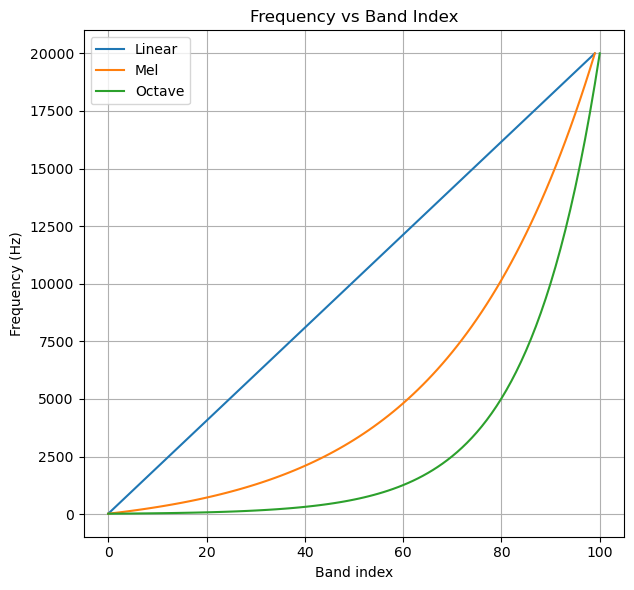

In [33]:
import matplotlib.pyplot as plt

# Create example scales
lin_scale = LinScale(20, 20000, 100)
mel_scale = MelScale(20, 20000, 100)
oct_scale = OctScale(20, 20000, 10)

# Plot frequency scales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lin_scale.F, label='Linear')
plt.plot(mel_scale.F, label='Mel')
plt.plot(oct_scale.F, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Band Index')
plt.legend()
plt.grid(True)

plt.subplot(2,2,1)
plt.plot(lin_scale.Q, label='Linear')
plt.plot(mel_scale.Q, label='Mel')
plt.plot(oct_scale.Q, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Q')
plt.title('Q vs Band Index')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


In [34]:
def hannwin(l):
    r = torch.arange(l,dtype=float)
    r *= torch.pi*2./l
    r = torch.cos(r)
    r += 1.
    r *= 0.5
    return r



In [ ]:
from warnings import warn

"""
Thomas Grill, 2011-2015
http://grrrr.org/nsgt

--
        Original matlab code comments follow:

NSGFWIN.M
---------------------------------------------------------------
 [g,rfbas,M]=nsgfwin(fmin,bins,sr,Ls) creates a set of windows whose
 centers correspond to center frequencies to be
 used for the nonstationary Gabor transform with varying Q-factor. 
---------------------------------------------------------------

INPUT : fmin ...... Minimum frequency (in Hz)
        bins ...... Vector consisting of the number of bins per octave
        sr ........ Sampling rate (in Hz)
        Ls ........ Length of signal (in samples)

OUTPUT : g ......... Cell array of window functions.
         rfbas ..... Vector of positions of the center frequencies.
         M ......... Vector of lengths of the window functions.

AUTHOR(s) : Monika Dörfler, Gino Angelo Velasco, Nicki Holighaus, 2010

COPYRIGHT : (c) NUHAG, Dept.Math., University of Vienna, AUSTRIA
http://nuhag.eu/
Permission is granted to modify and re-distribute this
code in any manner as long as this notice is preserved.
All standard disclaimers apply.

EXTERNALS : firwin
"""

def nsgfwin(f : Tensor, q: Tensor, sr, Ls, min_win=4, do_warn=True, dtype=torch.float64):
    """
    f: list of center frequencies
    q: list of Q-factors
    sr: sampling rate
    Ls: length of signal
    # sliced: if True, use sliced windows, otherwise use non-sliced windows
    min_win: minimum window length
    # Qvar: Q-factor variance

    Returns:
        g: list of window functions
        rfbas: list of center frequencies
        M: list of window lengths
    """

    nyquist_f = sr/2.0

    mask = f > 0
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly <= 0 
        f = f[lim:]
        q = q[lim:]
            
    mask = f >= nyquist_f
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly >= nf 
        f = f[:lim]
        q = q[:lim]
    
    # assert len(f) == len(q)
    assert torch.all((f[1:]-f[:-1]) > 0)  # frequencies must be monotonic
    assert torch.all(q > 0)  # all q must be > 0
    
    qneeded = f*(Ls/(8.*sr))
    if torch.any(q >= qneeded) and do_warn:
        warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
    
    fbas : Tensor[int] = f
    lbas : int = len(fbas)
    frqs = torch.concatenate([
        tensor([0.0])
        ,f,
        tensor([nyquist_f])
    ])
    fbas = torch.concatenate([frqs, tensor([sr]) - torch.flip(f, (0,))])

    fbas *= float(Ls)/sr

    M : Tensor = torch.zeros(fbas.shape, dtype=int)

    M[0] = torch.round(2*fbas[1])
    for k in range(1,2*lbas+1):
        M[k] = torch.round(fbas[k+1]-fbas[k-1])
    M[-1] = torch.round(Ls-fbas[-2])

    M = torch.clip(M, min_win, torch.inf)

    g : list = [hannwin(m) for m in M]

    fbas[lbas] = (fbas[lbas-1]+fbas[lbas+1])/2
    fbas[lbas+2] = Ls-fbas[lbas]
    rfbas = torch.round(fbas).to(int)

    return g, rfbas, M


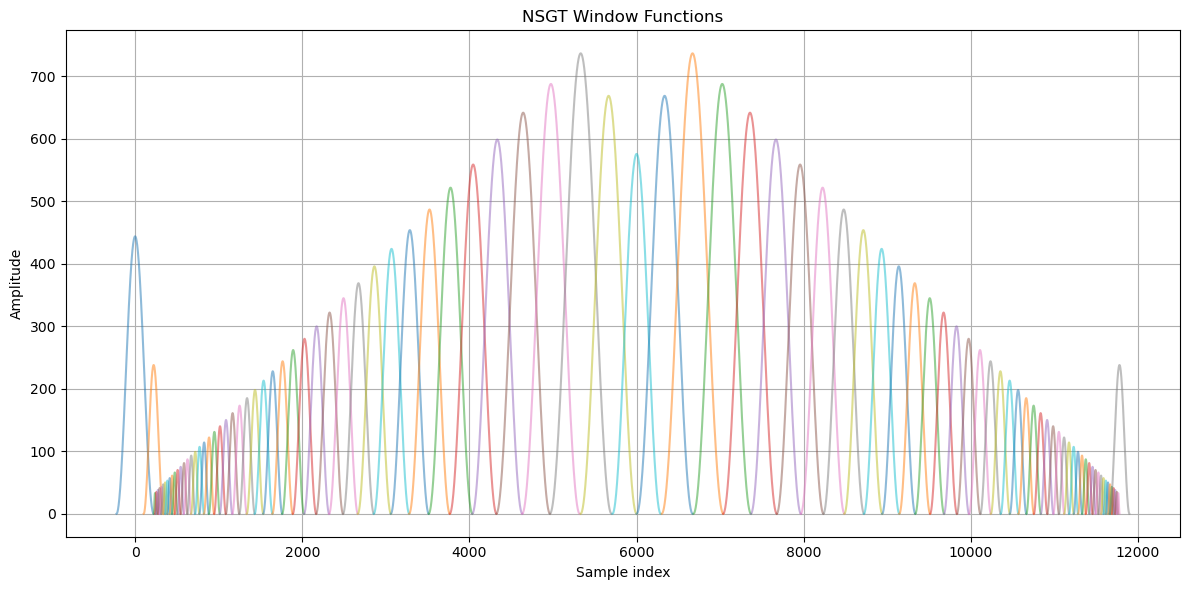

In [64]:
f = oct_scale.F
q = oct_scale.Q

sr = 1080
Ls = 12000

g, rfbas, M = nsgfwin(f,q,sr,Ls)

def plot_nsgfwin_results(g, rfbas, M):
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot each window function
    for i, window in enumerate(g):
        # Center each window at its frequency position
        center = rfbas[i]
        x = torch.arange(len(window)) + center - len(window)//2
        ax.plot(x, M[i]- window * M[i], alpha=0.5, label=f'Window {i}')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude') 
    ax.set_title('NSGT Window Functions')
    ax.grid(True)
    
    # Only show legend if there aren't too many windows
    if len(g) <= 10:
        ax.legend()
        
    plt.tight_layout()
    return fig

# Test the plotting function
f = plot_nsgfwin_results(g, rfbas, M)

In [ ]:
torch.tensor([0.0])

tensor([0.])